# Check GPU

In [ ]:
!nvidia-smi

Fri Nov 25 15:58:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    34W /  70W |   9272MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, utils, callbacks
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from imutils import paths

# Load dataset

In [ ]:
CATEGORIES = ['heart', 'oblong', 'oval', 'round', 'square']
epochs=50
batch_size = 32
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)


In [ ]:
trainDS = utils.image_dataset_from_directory(
    '/content/drive/MyDrive/CS331/imageDropData/train',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    color_mode='rgb',
)

testDS = utils.image_dataset_from_directory(
    '/content/drive/MyDrive/CS331/imageDropData/test',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    color_mode='rgb',
)

Found 4000 files belonging to 5 classes.
Found 1000 files belonging to 5 classes.


# Load pretrained model

In [ ]:

preprocessInput = tf.keras.applications.vgg16.preprocess_input

baseModel = VGG16(input_shape=IMG_SHAPE,
              include_top=False,
              weights='imagenet')
baseModel.trainable = False

# Build model

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))

x = preprocessInput(inputs)
x = baseModel(x, training=False)
x = layers.Flatten()(x)
outputs = layers.Dense(5)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 5)                 1254

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [ ]:
checkpointPath = "/content/drive/MyDrive/CS331/FaceOnly/VGG16/checkpoint/model-{epoch:02d}-{val_accuracy:.2f}.h5"

In [ ]:
modelEarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    min_delta=0.025,
    verbose=1,
    mode='auto',
    restore_best_weights=False,
)

modelCheckpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpointPath,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose = 1,
    mode='max'
)


# Train model

In [ ]:
with tf.device('/gpu:0'):
    history = model.fit(
            trainDS,
            validation_data=testDS,
            epochs=epochs,
            callbacks = [modelEarlyStopping, modelCheckpoint]
    )

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 6.4297 - accuracy: 0.4527
Epoch 1: val_accuracy improved from -inf to 0.52700, saving model to /content/drive/MyDrive/CS331/FaceOnly/VGG16/checkpoint/model-01-0.53.h5
125/125 [==============================] - 30s 230ms/step - loss: 6.4297 - accuracy: 0.4527 - val_loss: 5.9999 - val_accuracy: 0.5270
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 1.7835 - accuracy: 0.7638
Epoch 2: val_accuracy improved from 0.52700 to 0.56400, saving model to /content/drive/MyDrive/CS331/FaceOnly/VGG16/checkpoint/model-02-0.56.h5
125/125 [==============================] - 28s 220ms/step - loss: 1.7835 - accuracy: 0.7638 - val_loss: 5.3517 - val_accuracy: 0.5640
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 1.0398 - accuracy: 0.8540
Epoch 3: val_accuracy improved from 0.56400 to 0.57300, saving model to /content/drive/MyDrive/CS331/FaceOnly/VGG16/checkpoint/model-03-0.57.h5
125/125 [======

# Plot loss and accuracy

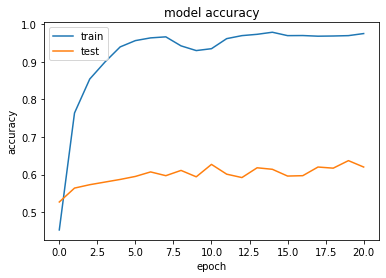

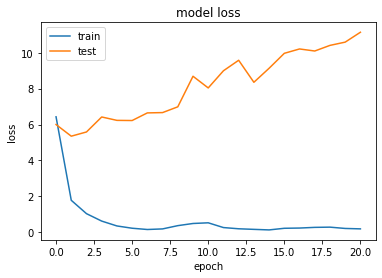

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test model

In [ ]:
def loadData(path):
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []

    for imagePath in tqdm(imagePaths):
        label = imagePath.split(os.path.sep)[-2]
        # Read image
        image = cv2.imread(imagePath)

        # Resize
        imageResize = cv2.resize(image, (224,224))


        data.append(imageResize)
        labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    lb = LabelEncoder()
    labels = lb.fit_transform(labels)
    return data, labels

In [ ]:
xTest, yTest = loadData(('/content/drive/MyDrive/CS331/imageDropData/test'))

100%|██████████| 1000/1000 [00:05<00:00, 180.59it/s]


In [ ]:
newModel = keras.models.load_model('/content/drive/MyDrive/CS331/FaceOnly/VGG16/checkpoint/model-20-0.64.h5')

In [ ]:
zScores = newModel.predict(xTest)
yPred = np.argmax(zScores, axis=1)
corrects = (yTest == yPred).sum()
print(f'Model predict {corrects}/{len(yTest)} corrects')

32/32 [==============================] - 5s 167ms/step
Model predict 507/1000 corrects


## Confusion matrix

[]

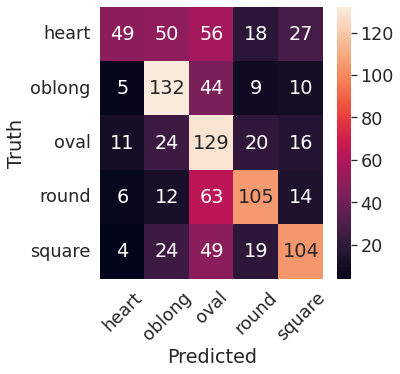

In [ ]:
cm = tf.math.confusion_matrix(labels=yTest, predictions=yPred)
plt.figure(figsize=(5,5))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['heart', 'oblong', 'oval', 'round', 'square'],
            yticklabels=['heart', 'oblong', 'oval', 'round', 'square'],
            )
plt.xticks(rotation=45)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.plot()


## Classification report

In [ ]:
print(classification_report(yTest, yPred,target_names=['heart', 'oblong', 'oval', 'round', 'square']))

              precision    recall  f1-score   support

       heart       0.65      0.24      0.36       200
      oblong       0.55      0.66      0.60       200
        oval       0.38      0.65      0.48       200
       round       0.61      0.53      0.57       200
      square       0.61      0.52      0.56       200

    accuracy                           0.52      1000
   macro avg       0.56      0.52      0.51      1000
weighted avg       0.56      0.52      0.51      1000

